# TC Profiling


In [1]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import seaborn

## SFC / VNF Model

The first approach for a simplistic SFC / VNF performance model that can be used to play with different profiling approaches. As a first shot, the model tries to mimic the results from our NFV-SDN'17 paper [1]. The model focusses only on throughput as main metric for now. 


<small>
* [1] M. Peuster and H. Karl: Profile Your Chains, Not Functions: Automated Network Service Profiling in DevOps Environments. IEEE Conference on Network Function Virtualization and Software Defined Networks (NFV-SDN), Berlin, Germany. (2017) 
</small>

In [58]:
class NS(object):
    """
    A network service based on a linear SFC: f1 -> f2 -> ... -> fN 
    """
    
    def __init__(self, name, vnfs, alphas = None):
        """
        name: name of service (string)
        vnfs: vector of functions representing the VNF's CPU-time -> throughput mapping
        alphas: vector of floats to scale the performance of a VNF at the corresponding position (set to [1.0,...,1.0] if None)
        """
        self.name = name
        self.vnfs = vnfs
        self.alphas = alphas if alphas else [1.0 for _ in self.vnfs]
        print("Initialized '{}' with alphas={}".format(self.name, self.alphas))   
        
    def _calc_vnf_tp(self, cpu_times):
        """
        calculate TP for each function in self.vnfs
        cpu_times: CPU time available for each VNF
        """
        assert len(cpu_times) == len(self.vnfs) == len(self.alphas)
        # calculate result for each vnf and multiply by corresponding alpha
        return [f(r) * a for f, r, a in zip(self.vnfs, cpu_times, self.alphas)]
           
    def get_total_tp(self, cpu_times):
        """
        calculate TP of SFC
        cpu_times: CPU time available for each VNF
        """
        # uses "naive" minimum-TP model from NFV-SDN'17 paper for now
        return min(self._calc_vnf_tp(cpu_times))


In [59]:
#
# Model tests
#
# test with simple linear models (based on NFV-SDN'17 paper results)
vnfs = [
    lambda x: 8.0 * x,
    lambda x: 3.0 * x,
    lambda x: 1.2 * x
]

n1 = NS("n1", vnfs)
print(n1.get_total_tp([0.16, 0.16, 0.16]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))

n2 = NS("n2", vnfs, alphas=[np.random.uniform(0.2, 5.0) for _ in vnfs])
print(n2.get_total_tp([0.16, 0.16, 0.16]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))

Initialized 'n1' with alphas=[1.0, 1.0, 1.0]
0.192
1.2
1.2
Initialized 'n2' with alphas=[2.0743697790908966, 0.2908535448096199, 1.76383778857386]
0.13960970150861754
0.8725606344288597
0.8725606344288597


In [85]:
# use simple linear models (based on NFV-SDN'17 paper results)
def rotate(l, x):
    """
    helper to permutate VNF list
    """
    return l[-x:] + l[:-x]

vnfs = [
    lambda x: 8.0 * x,
    lambda x: 3.0 * x,
    lambda x: 1.2 * x
]

# generate random alphas (NFV-SDN'17 paper has variance up to 6.0x)
alphas=[np.random.uniform(0.2, 5.0) for _ in vnfs]
# generate one service instance without any random effects
ns_list = list()
ns_base = NS("NS_base", vnfs.copy())
ns_list.append(ns_base)
# generate three service instances and rotate the order of the VNFs (scaling for each position is random but fixed accross NS instances)
ns_1 = NS("NS_1", vnfs.copy(), alphas=alphas)
ns_list.append(ns_1)
ns_2 = NS("NS_2", rotate(vnfs.copy(), 1), alphas=alphas)
ns_list.append(ns_2)
ns_3 = NS("NS_3", rotate(vnfs.copy(), 2), alphas=alphas)
ns_list.append(ns_3)

# generate list with configurations
configs = list()
for c1 in [0.16, 0.32, 0.64]:
    for c2 in [0.16, 0.32, 0.64]:
        for c3 in [0.16, 0.32, 0.64]:
            configs.append((c1, c2, c3))
print("Generated {} configs.".format(len(configs)))

ns_results = list()
for ns in ns_list:
    ns_results.append([ns.get_total_tp(c) for c in configs])

Initialized 'NS_base' with alphas=[1.0, 1.0, 1.0]
Initialized 'NS_1' with alphas=[2.9467690898310726, 2.8263747822327816, 0.48920306327125174]
Initialized 'NS_2' with alphas=[2.9467690898310726, 2.8263747822327816, 0.48920306327125174]
Initialized 'NS_3' with alphas=[2.9467690898310726, 2.8263747822327816, 0.48920306327125174]
Generated 27 configs.


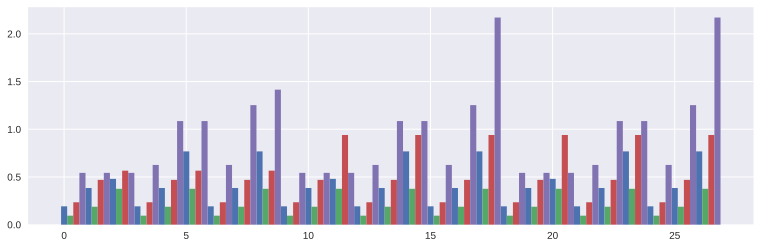

In [89]:
#
# plot
#

def bar_plot(configs, ns_list, ns_results):
    plt.figure(figsize=(13,4))
    X = np.arange(len(configs))
    plt.bar(X + 0.00, ns_results[0] , width = 0.25)
    plt.bar(X + 0.25, ns_results[1] , width = 0.25)
    plt.bar(X + 0.50, ns_results[2] , width = 0.25)
    plt.bar(X + 0.75, ns_results[3] , width = 0.25)

bar_plot(configs, ns_list, ns_results)